In [231]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import os

In [232]:
def histogram(data: pd.Series, title, normalize=True, show_values=True, save_png=True):
    data = data.dropna()
    labels, counts = np.unique(data, return_counts=True)
    
    if normalize:
        counts = 100 * (counts/counts.sum())
        
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    
    if show_values:
        xlocs, _ = plt.xticks()
        for i, v in enumerate(counts):
            plt.text(xlocs[i] - 0.25, v + 0.01, f"{v:.1f}{'%' if normalize else ' '}")
            
    plt.title(title)
    
    if save_png and os.name != "nt":  # buggy on windows...
        plt.savefig(f"../pngs/{title}.png")

In [233]:
df = pd.read_csv("../res/Sondage - Augmentation des Taxes d'Étude (réponses) - Réponses au formulaire 1.csv")
df.head(5)

,Horodateur,Question sur la nationalité // Question about nationality,Question sur le diplôme d'études secondaires suisse // Question about the high school diploma,"Conséquences - Si les taxes d’études devaient augmenter, devrais-tu travailler à côté des études ? // If tuition fees were to increase, would you need to work alongside your studies?",Niveau d’augmentation - Serais-tu venu·e à l'EPFL si les taxes d'étude étaient 3 fois plus grandes ? // Would you have come to EPFL if tuition fees were 3 times bigger?,Niveau d’augmentation - A partir de quel facteur d’augmentation est-ce qu’une augmentation des taxes d’études aurait un impact sur ton mode de vie ? // From what factor of increase would a rise in tuition fees impact your lifestyle?,Opinion - Est-ce que tu es d'accord avec la proposition de triplement des taxes d'étude pour les étudiant·e·s étranger·ère·s ? // Do you agree with the proposal to triple the tuition fees for international students?,Remarques sur la proposition // Remarks on the proposition,Remarques diverses // Misc remarks
0,29/05/2024 09:54:38,Je n'ai pas la nationalité suisse mais j'ai un...,Je n'ai pas de diplôme suisse mais j'ai un dip...,Oui,3.0,2.0,1.0,NaN,NaN
1,29/05/2024 09:54:42,Je n'ai ni de nationalité suisse ni de nationa...,Je n'ai ni diplôme suisse ni diplôme européen ...,Oui,4.0,1.0,5.0,NaN,NaN
2,29/05/2024 09:54:43,Je n'ai pas la nationalité suisse mais j'ai un...,Je n'ai pas de diplôme suisse mais j'ai un dip...,Oui,1.0,2.0,1.0,NaN,NaN
3,29/05/2024 09:54:51,Je n'ai ni de nationalité suisse ni de nationa...,Je n'ai pas de diplôme suisse mais j'ai un dip...,Oui,5.0,3.0,1.0,NaN,NaN
4,29/05/2024 09:54:57,Je n'ai pas la nationalité suisse mais j'ai un...,Je n'ai pas de diplôme suisse mais j'ai un dip...,Je le fais déjà,1.0,5.0,1.0,NaN,NaN


In [234]:
opinion_str = "Opinion - Est-ce que tu es d'accord avec la proposition de triplement des taxes d'étude pour les étudiant·e·s étranger·ère·s ? // Do you agree with the proposal to triple the tuition fees for international students?"
work_str = "Conséquences - Si les taxes d’études devaient augmenter, devrais-tu travailler à côté des études ? // If tuition fees were to increase, would you need to work alongside your studies? "
nationality_str = "Question sur la nationalité // Question about nationality"
diploma_str = "Question sur le diplôme d'études secondaires suisse // Question about the high school diploma"
coming_str = "Niveau d’augmentation - Serais-tu venu·e à l'EPFL si les taxes d'étude étaient 3 fois plus grandes ? // Would you have come to EPFL if tuition fees were 3 times bigger? "

In [235]:
df[opinion_str] = df[opinion_str] - 1
df[coming_str] = df[coming_str] - 1
# Bring from [1,5] range to [0, 4]

In [236]:
def nationality_str_to_enum(nation_str: str) -> str | float:
    match nation_str:
        case "Je n'ai pas la nationalité suisse mais j'ai une nationalité européenne // I don't have the Swiss nationality but I have a European nationality": return "European"
        case "Je n'ai ni de nationalité suisse ni de nationalité européenne // I have neither the Swiss nor a European nationality": return "Neither"
        case "J'ai la nationalité suisse // I have the Swiss nationality": return "Swiss"
        case _ : return np.nan


df[nationality_str] = df[nationality_str].apply(nationality_str_to_enum)

In [237]:
def diploma_str_to_enum(dip_str: str) -> str | float:
    match dip_str:
        case "Je n'ai pas de diplôme suisse mais j'ai un diplôme européen // I don't have a Swiss diploma but I have a European diploma": return "European"
        case "Je n'ai ni diplôme suisse ni diplôme européen // I have neither a Swiss diploma nor a European one": return "Neither"
        case "J'ai un diplôme suisse // I have a Swiss diploma": return "Swiss"
        case _ : return np.nan
    
df[diploma_str] = df[diploma_str].apply(diploma_str_to_enum)    

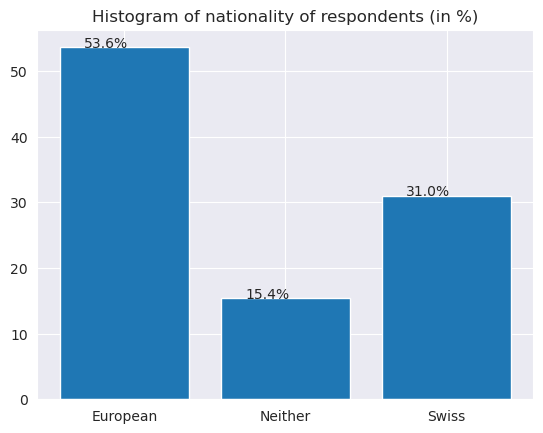

In [238]:
histogram(df[nationality_str], "Histogram of nationality of respondents (in %)")

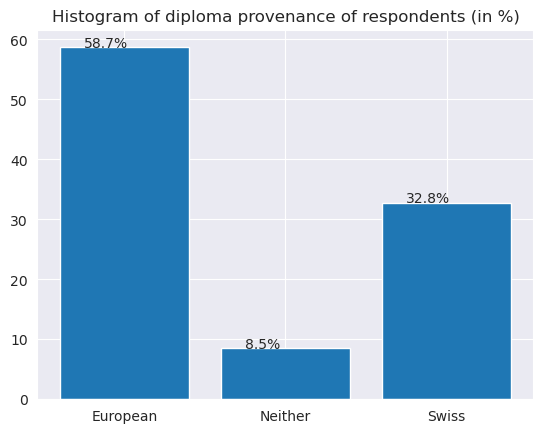

In [239]:
histogram(df[diploma_str], "Histogram of diploma provenance of respondents (in %)")

In [240]:
swiss = df[nationality_str] == "Swiss"
non_swiss = df[nationality_str] != "Swiss"
opinion = df[opinion_str]

In [241]:
nan_mask = np.isnan(opinion) | np.isnan(swiss)
swiss_num = swiss[~nan_mask]
opinion = opinion[~nan_mask]

In [242]:
print(f"PearsonR correlation between the opinion on the increase and the event of being swiss:\n\t{stats.pearsonr(opinion, swiss_num)}")

PearsonR correlation between the opinion on the increase and the event of being swiss:
	PearsonRResult(statistic=0.5148757887230726, pvalue=2.734155229526372e-85)


In [243]:
print(f"Mean opinion on the increase: {np.mean(df[opinion_str]) : .3f}/4")

Mean opinion on the increase:  0.747/4


In [244]:
print(f"Mean Swiss opinion on the increase: {np.mean(df[swiss][opinion_str]) : .3f}/4")

Mean Swiss opinion on the increase:  1.813/4


In [245]:
print(f"Mean non Swiss opinion on the increase: {np.mean(df[non_swiss][opinion_str]) : .3f}/4")

Mean non Swiss opinion on the increase:  0.271/4


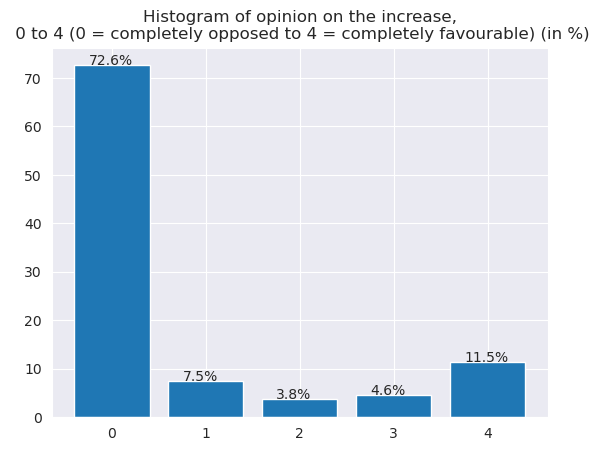

In [246]:
histogram(df[opinion_str], "Histogram of opinion on the increase,\n 0 to 4 (0 = completely opposed to 4 = completely favourable) (in %)")

In [247]:
print(f"Number of respondents: {len(df[opinion_str].dropna())}")

Number of respondents: 1246


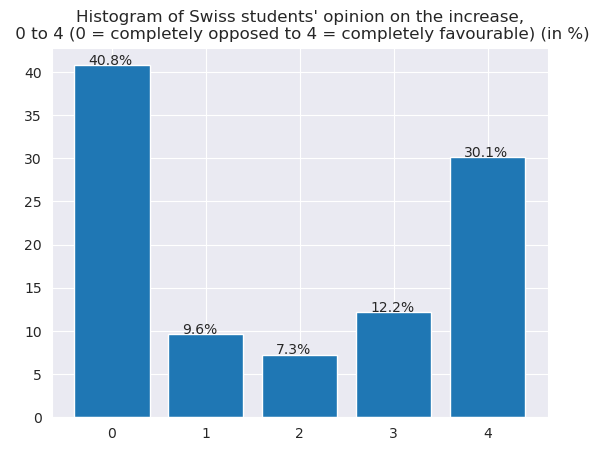

In [248]:
histogram(df[swiss][opinion_str], title="Histogram of Swiss students' opinion on the increase,\n 0 to 4 (0 = completely opposed to 4 = completely favourable) (in %)")

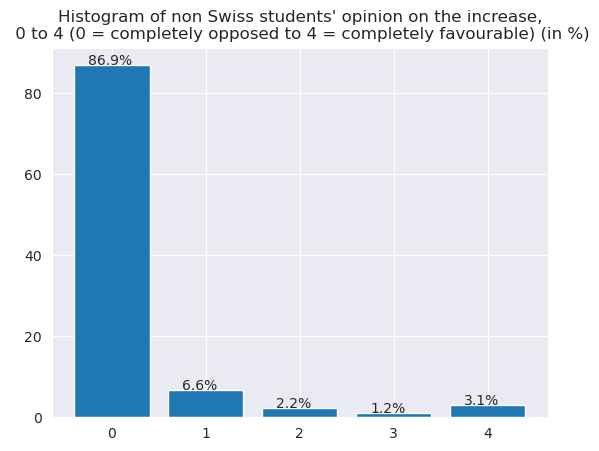

In [249]:
histogram(df[non_swiss][opinion_str], title="Histogram of non Swiss students' opinion on the increase,\n 0 to 4 (0 = completely opposed to 4 = completely favourable) (in %)")

In [250]:
print(f"Number of Swiss respondents: {len(df[swiss][opinion_str].dropna())}")

Number of Swiss respondents: 385


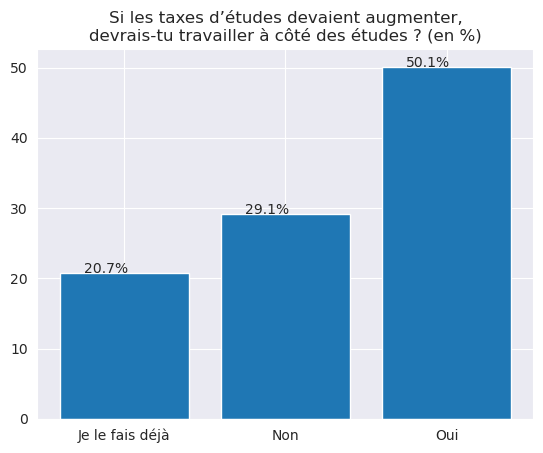

In [254]:
histogram(df[non_swiss][work_str], title="Si les taxes d’études devaient augmenter,\ndevrais-tu travailler à côté des études ? (en %)", normalize=True)

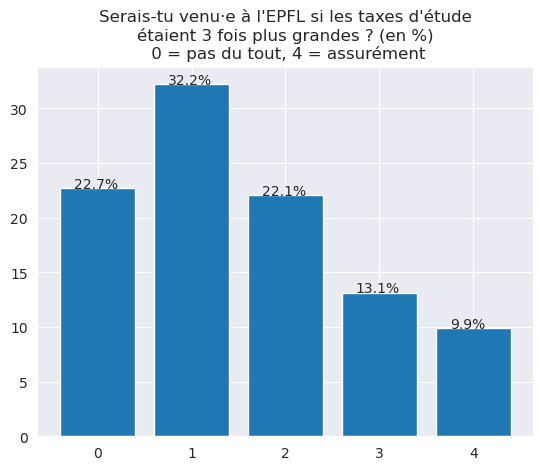

In [255]:
histogram(df[non_swiss][coming_str], title="Serais-tu venu·e à l'EPFL si les taxes d'étude\nétaient 3 fois plus grandes ? (en %)\n 0 = pas du tout, 4 = assurément")

In [253]:
# Sanity check: opinion is stationary with time (checks against potential mass votes against/for tripling). The output of this cell is a probability. The closer it is to 1, the better.

opinion = opinion.dropna()
batch_size = 100
nb_batches = len(opinion) // batch_size

min_pval = 1 
i_min_pval = -1
j_min_pval = -1

for i in range(nb_batches):
    for j in range(nb_batches):
        curr_pval = stats.ks_2samp(opinion[i:i+batch_size], opinion[j:j+batch_size]).pvalue
        
        if curr_pval < min_pval:
            min_pval = curr_pval
            i_min_pval = i 
            j_min_pval = j
        
min_pval

0.999998821968263